# STIFMap Generation Notebook

The goal of this notebook is to allow users to generate STIFMaps for their own images or sample images available from the manuscript.

## Import necessary packages

In [1]:
# Import functions from the STIFMaps package
from STIFMaps import STIFMap_generation
from STIFMaps.misc import get_step

In [2]:
# Other imports
import os
import numpy as np
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt

from scipy.stats import spearmanr
from scipy import interpolate

import time

## Generate STIFMap for an image of interest

### Specify input files

STIFMaps are generated from paired DAPI and collagen images from the same sample. Additionally, it is necessary to download trained networks to predict collagen stiffness from the `trained_models` folder on [Mendeley](https://data.mendeley.com/datasets/vw2bb5jy99/2). It's recommended to use the first five trained models.

Example images for use in this notebook are available via [GitHub](https://github.com/cstashko/STIFMaps/tree/master/test_cases)

In [3]:
# Specify the DAPI and collagen images to be overlaid
dapi = '/home/connor/Documents/STIFMaps/test_cases/with_stain/test1_DAPI.TIF'
collagen = '/home/connor/Documents/STIFMaps/test_cases/with_stain/test1_collagen.TIF'

# If saving, what should the sample be called?
name = 'test'

# Specify the models to use for stiffness predictions:
model_dir = '/home/connor/Documents/STIFMaps/trained_models/'
models = [model_dir+model for model in os.listdir(model_dir)]

# List the models
models

['/home/connor/Documents/STIFMaps/trained_models/iteration_1002.pt',
 '/home/connor/Documents/STIFMaps/trained_models/iteration_1003.pt',
 '/home/connor/Documents/STIFMaps/trained_models/iteration_1000.pt',
 '/home/connor/Documents/STIFMaps/trained_models/iteration_1004.pt',
 '/home/connor/Documents/STIFMaps/trained_models/iteration_1001.pt']

### Specify Parameters

These parameters specify the resolution conversion between the input image and the imaging data used to train the models, how many different points to predict stiffness, and how many points to evaluate at once with the model. Note that the choice of `step` is a tradeoff between resolution vs runtime and memory usage while `batch_size` is a tradeoff between memore usage and runtime.

In [7]:
# Networks were trained at a microscopy resolution of 4.160 pixels/micron (0.2404 microns/pixel)
# Provide a scale factor to resize the input images to this resolution
# Ex: Images at 2.308 pixels/micron require a scale_factor of 1.802
scale_factor = 1.802

# Stifness is predicted for each square. This is the distance from the center of one square to the next
step = 200

# How many squares to evaluate at once with the network
batch_size = 100

### Given the scale_factor, what are the actual square dimensions and step sizes that will be used?

In [8]:
# Given the scale_factor, what is the actual step size (in pixels) from one square to the next?
step = get_step(step, scale_factor)

print('Step size is ' + str(step) + ' pixels')

# Get the actual side length of one square
# The models expect input squares that are 224 x 224 pixels. 
# Given the scale_factor, how many pixels is that in these images?
square_side = get_step(224, scale_factor)

print('Side length for a square is ' + str(square_side) + ' pixels')

Step size is 110 pixels
Side length for a square is 124 pixels


### Get STIFMap

STIFMaps are computed using the function `generate_STIFMap`, which has the following inputs:
 - **dapi**: The path to the DAPI image to use
 - **collagen**: The path to the collagen image to use
 - **name**: The prefix to use for saving the predictions, if 'save_dir' is specified
 - **step**: The step size to use between squares
 - **models**: The list of trained networks to use for predictions
 - **mask**: (Optional) The path to a 2D mask the same dimension as 'dapi' of zeros and ones that specifies regions to exclude when predicting stiffness 
 - **batch_size**: How many squares should be evaluated by one model at once
 - **square_side**: The side length of each square to evaluate in the model
 - **save_dir**: Where to save the stiffness predictions, or 'False' if saving is not desired
 
Output: `generate_STIFMap` returns a 3D numpy array of the stiffness predictions for the 'dapi'/'collagen' images for each of the included models

Device is cpu
Image shape is (3, 1800, 1800)
Num squares in x direction is 16
Num squares in y direction is 16
Time taken to predict squares is 6.835830450057983
Time taken to predict squares is 12.934874534606934
Time taken to predict squares is 18.267839193344116
Time taken to predict squares is 23.41127872467041
Time taken to predict squares is 29.002824783325195
Total time taken is 29.31339693069458


/home/connor/anaconda3/envs/STIFMaps/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


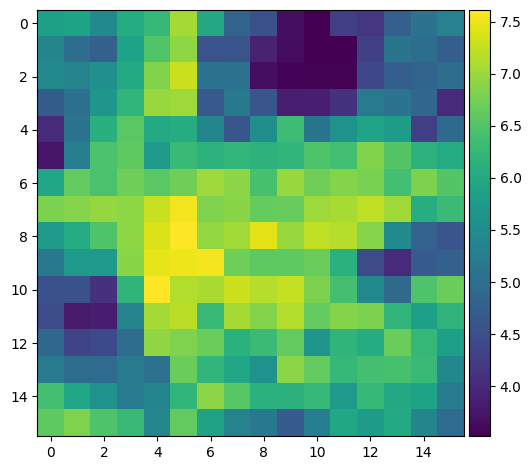

In [9]:
# Generate the stiffness predictions
z_out = STIFMap_generation.generate_STIFMap(dapi, collagen, name, step, models=models,
                    mask=False, batch_size=100, square_side=square_side,
                    save_dir=False)

# Show the output image
io.imshow(np.mean(z_out, axis=0))

## Collagen Painting

The collagen image may be pseudocolored to indicate the predicted stiffness of the collagen fibers. This is done using the function `collagen_paint`, which has the following inputs:

 - **dapi**: The path to the DAPI image to use
 - **collagen**: The path to the collagen image to use
 - **z**: The stiffness prediction values computed above
 - **name**: The prefix to use for saving the predictions, if 'save_dir' is specified
 - **step**: The step size used between squares
 - **mask**: (Optional) The path to a 2D mask the same dimension as 'dapi' of zeros and ones that specifies regions to exclude when coloring collagen 
 - **square_side**: The side length of each square evaluated in the model
 - **scale_percent**: An integer from 1-100 specifying how much to scale down the images if memory usage or runtime is too high. Note that a value of 100 means that the images will not be scaled down at all
 - **save_dir**: Where to save the collagen-painted image, or 'False' if saving is not desired
 
Output: In addition to saving the collagen-painted image (if specified), `collagen_paint` returns an RGB image of the pseudocolored collagen

In [10]:
col_colored = STIFMap_generation.collagen_paint(dapi, collagen, z_out, name, step,
                    mask=False, square_side=square_side,
                    scale_percent=100, save_dir=False)

# Show the pseudocolored collagen image
io.imshow(col_colored)

test


NameError: name 'cv2' is not defined

# Correlate predicted stiffness with a staining marker of interest

Given an additional staining image taken at the same region as the DAPI and collagen images, we can compute the correlation between the staining intensity and the intensity of collagen, DAPI, and predicted stiffness using the function `correlate_signals_with_stain`, which has the following inputs:

 - **dapi**: The path to the DAPI image to use
 - **collagen**: The path to the collagen image to use
 - **z**: The stiffness prediction values computed above
 - **stain**: The path to the staining image to use
 - **step**: The step size used between squares
 - **mask**: (Optional) The path to a 2D mask the same dimension as 'dapi' of zeros and ones that specifies regions to exclude when coloring collagen 
 - **square_side**: The side length of each square evaluated in the model
 - **scale_percent**: An integer from 1-100 specifying how much to scale down the images if memory usage or runtime is too high. Note that a value of 100 means that the images will not be scaled down at all
 - **quantile**: A float between zero and one specifying the quantile of stain intensity of use for each percentile of DAPI/collagen/STIFMap intensity. See the manuscript for more details
 
Output: `correlate_signals_with_stain` returns the Spearman correlation values between the staining intensity and the intensity of DAPI, collagen, and stiffness predictions

In [ ]:
# Specify the staining file to use
stain = '/home/connor/Documents/STIFMaps/test_cases/with_stain/test1_stain.TIF'

# The pixel threshold to use when comparing STIFMaps/DAPI/collagen vs stain intensity
quantile = .99

In [ ]:
# Correlate the stain intensity with the intensity of collagen, DAPI, and predicted stiffness
z_stain_corr, collagen_stain_corr, dapi_stain_corr = STIFMap_generation.correlate_signals_with_stain(
    dapi, collagen, z_out, stain, step,
    mask=False, square_side=square_side, 
    scale_percent=100, quantile=quantile)

In [ ]:
print(z_stain_corr)
print(collagen_stain_corr)
print(dapi_stain_corr)

In [11]:
import cv2

ModuleNotFoundError: No module named 'cv2'